In [1]:
library(randomForest)
library(partykit)
library(rpart)
library(mobForest)
library(e1071)
library(nnet)
library(caret)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loading required package: grid

Loading required package: libcoin

Loading required package: mvtnorm

Loading required package: parallel

Loading required package: party

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich


Attaching package: ‘party’


The following objects are masked from ‘package:partykit’:

    cforest, ctree, ctree_control, edge_simple, mob, mob_control,
    node_barplot, node_bivplot, node_boxplot, node_inner, node_surv,
    node_terminal, varimp


Loading required package: lattice

Loading required package: ggplot2

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


# Méthodes de machine learning

In [2]:
data_tot = read.csv('./Donnees/Plusieurs_pays/Total.csv', header = TRUE)
data_tot = data_tot[-c(47,60)]

Création d'un nouveau dataframe sans les variables `Rating` et `Pays`, utilisé après :

In [3]:
#data = data_tot[,-c(81,82,83,84)]
data = data_tot[,-c(34:46,55:60,72:84)]
data_but_tot = data * data_tot$Nombre

## Random Forest sur la variable Points

### Extraction d'un arbre de la forêt 

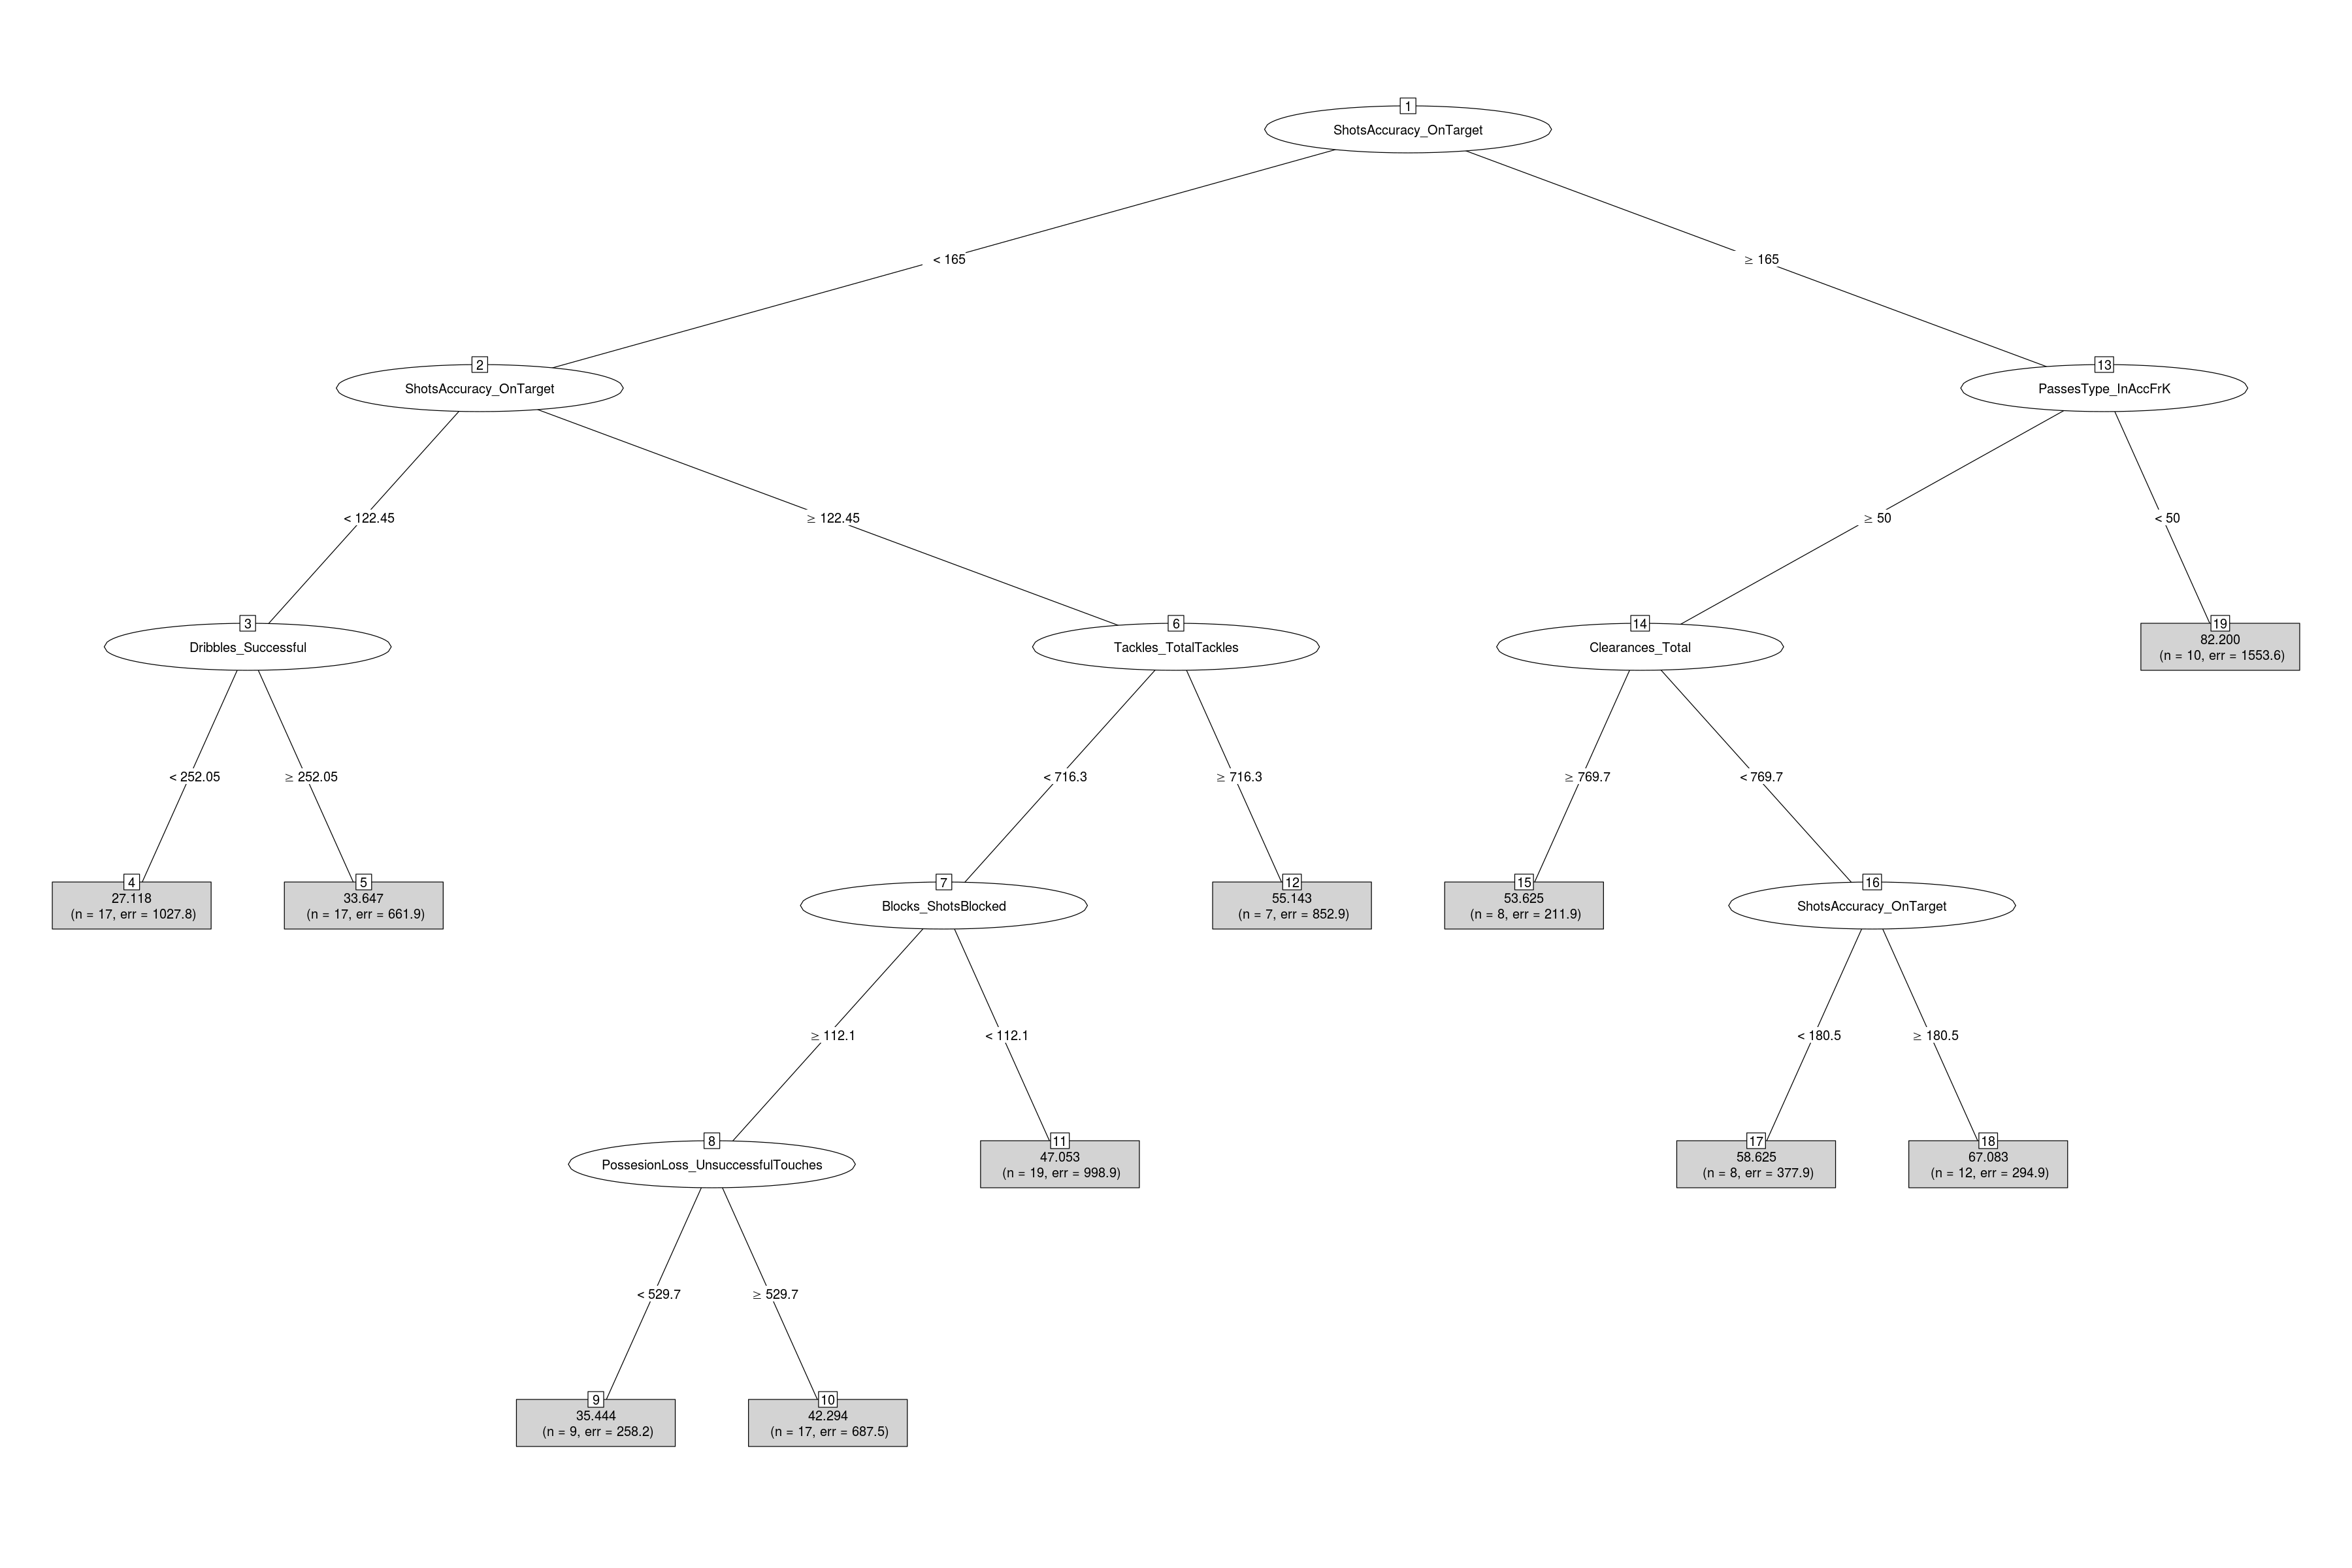

In [4]:
tree.points = rpart(data_tot$Points ~ ., data=data_but_tot, control=rpart.control(cp=0.0001))
        # le parametre cp permet de contrôler l'élagage de l'arbre

options(repr.plot.width=30, repr.plot.height=20)
plot(as.party(tree.points), type="simple")

Ici, la variable permettant de faire une première séparation, et qui est donc la plus importante est `ShotsAccuracy_OnTarget`. Elle réapparait encore après, sur chacun des deux sous arbres principaux. Cette variable est donc très importante pour la régression.

### Application du random Forest

In [5]:
#points.rf = randomForest(as.factor(data_tot$Points) ~ ., data=data_but_tot)
points.rf = randomForest(data_tot$Points ~ ., data=data_but_tot)

In [6]:
print(points.rf)


Call:
 randomForest(formula = data_tot$Points ~ ., data = data_but_tot) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 17

          Mean of squared residuals: 90.33871
                    % Var explained: 70.02


Ici on compte 10 variables importantes d'après RandomForest pour expliquer `Points`.

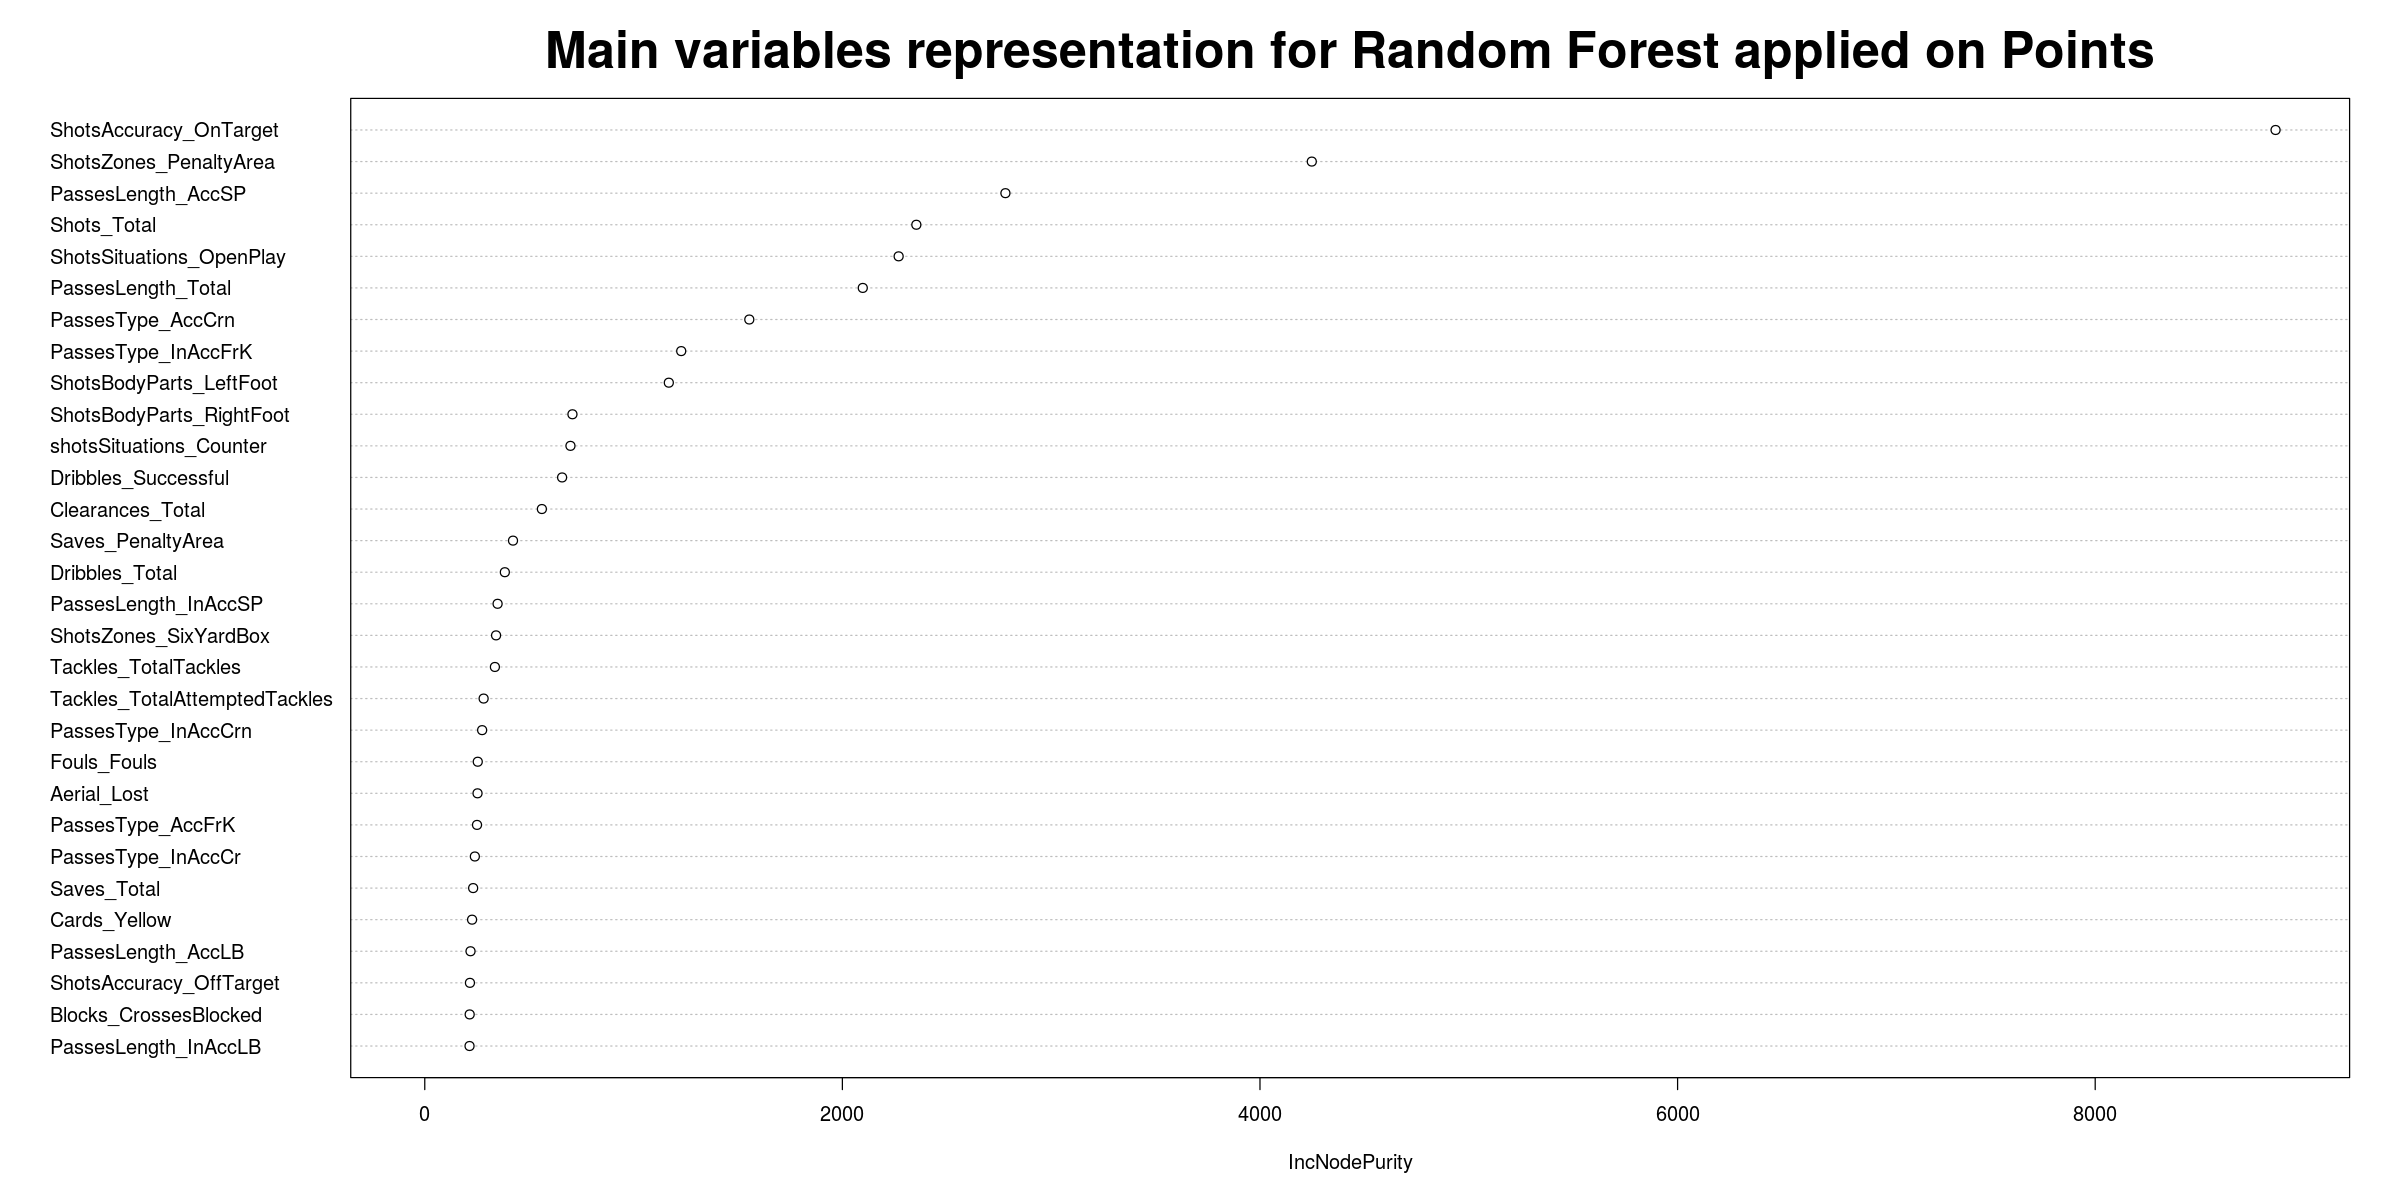

In [7]:
options(repr.plot.width=20, repr.plot.height=10)
varImpPlot(points.rf, main = "Main variables representation for Random Forest applied on Points", cex.main = 2.5)

Les principales variables mises en exergue par random forest sont `ShotsAccuracy_OnTarget`, `ShotsZones_PenaltyArea`, `Shots_Total`, `PassesLength_Total`, `PassesLength_AccSP`, `ShotsBodyParts_LeftFoot`, `ShotsSituations_OpenPlay`, `PasseType_InAccFrk` et `PassesType_AccCrn`

#### Prédiction sur le nombre de points

Il faut faire du nettoyage : en faisant de la régression ça marche, on a un $R2$ plutôt pas mal mais il fait de la régression donc on obtient des valeurs prédites non entières. Est-ce que si on récupère la partie entière des predict c'est trop faux ??

A l'inverse, quand on essaie de faire de la classification, où chaque classe = 1 entier, on prédit exactement les bonnes valeurs donc sans doute qu'on a fait du suraprentissage.

In [8]:
predict.points.rf = predict(points.rf, data_but_tot)
#predict.points.integer = as.numeric(as.character(predict.points))
#residus.points = data_tot$Points - predict.points.integer
residus.points.rf = data_tot$Points - predict.points.rf

In [37]:
sort(round(predict.points.rf), decreasing = TRUE)

Manchester City               Liverpool     Paris Saint-Germain 
                     90                      88                      87 
              Barcelona                Juventus           Bayern Munich 
                     86                      81                      81 
                 Napoli                 Chelsea                    Lyon 
                     79                      76                      75 
            Real Madrid               Tottenham                Atalanta 
                     71                      69                      68 
 RasenBallsport Leipzig                    Roma                   Lille 
                     68                      67                      66 
                  Inter                 Arsenal                  Torino 
                     66                      66                      65 
               AC Milan       Borussia Dortmund         Atletico Madrid 
                     65                      64                      62 
            Montpellier        Bayer Leverkusen              Hoffenheim 
                     61                      61                      61 
                  Lazio                 Sevilla           Saint-Etienne 
                     60                      60                      59 
              Marseille          Crystal Palace              Villarreal 
                     59                      59                      58 
              Leicester                Valencia                   Nimes 
                     58                      56                      55 
      Manchester United               Sampdoria                 Everton 
                     55                      54                      54 
                   Nice                   Eibar              Fiorentina 
                     53                      53                      52 
    Borussia M.Gladbach           Werder Bremen                  Rennes 
                     52                      52                      51 
    Eintracht Frankfurt               Wolfsburg              Celta Vigo 
                     51                      51                      51 
             Real Betis                West Ham Wolverhampton Wanderers 
                     51                      51                      51 
                 Nantes           Real Sociedad              Strasbourg 
                     50                      50                      49 
               Espanyol             Racing Club            Boca Juniors 
                     49                      49                      48 
                  Reims                  Getafe             River Plate 
                     47                      47                      47 
               Sassuolo                Mainz 05        Newcastle United 
                     46                      46                      46 
                 Angers         Athletic Bilbao                 Bologna 
                     45                      45                      44 
                  Genoa           Hertha Berlin     Fortuna Duesseldorf 
                     44                      44                      44 
                Leganes                 Watford             Bournemouth 
                     44                      44                      43 
               Bordeaux                  Monaco                 Udinese 
                     42                      42                      42 
                 Empoli                 Levante             Southampton 
                     42                      42                      42 
              SPAL 2013        Deportivo Alaves               SD Huesca 
                     41                      41                      41 
               Toulouse                Cagliari                  Girona 
                     40                      40                      40 
     Defensa y Justicia                   Dijon                Aug

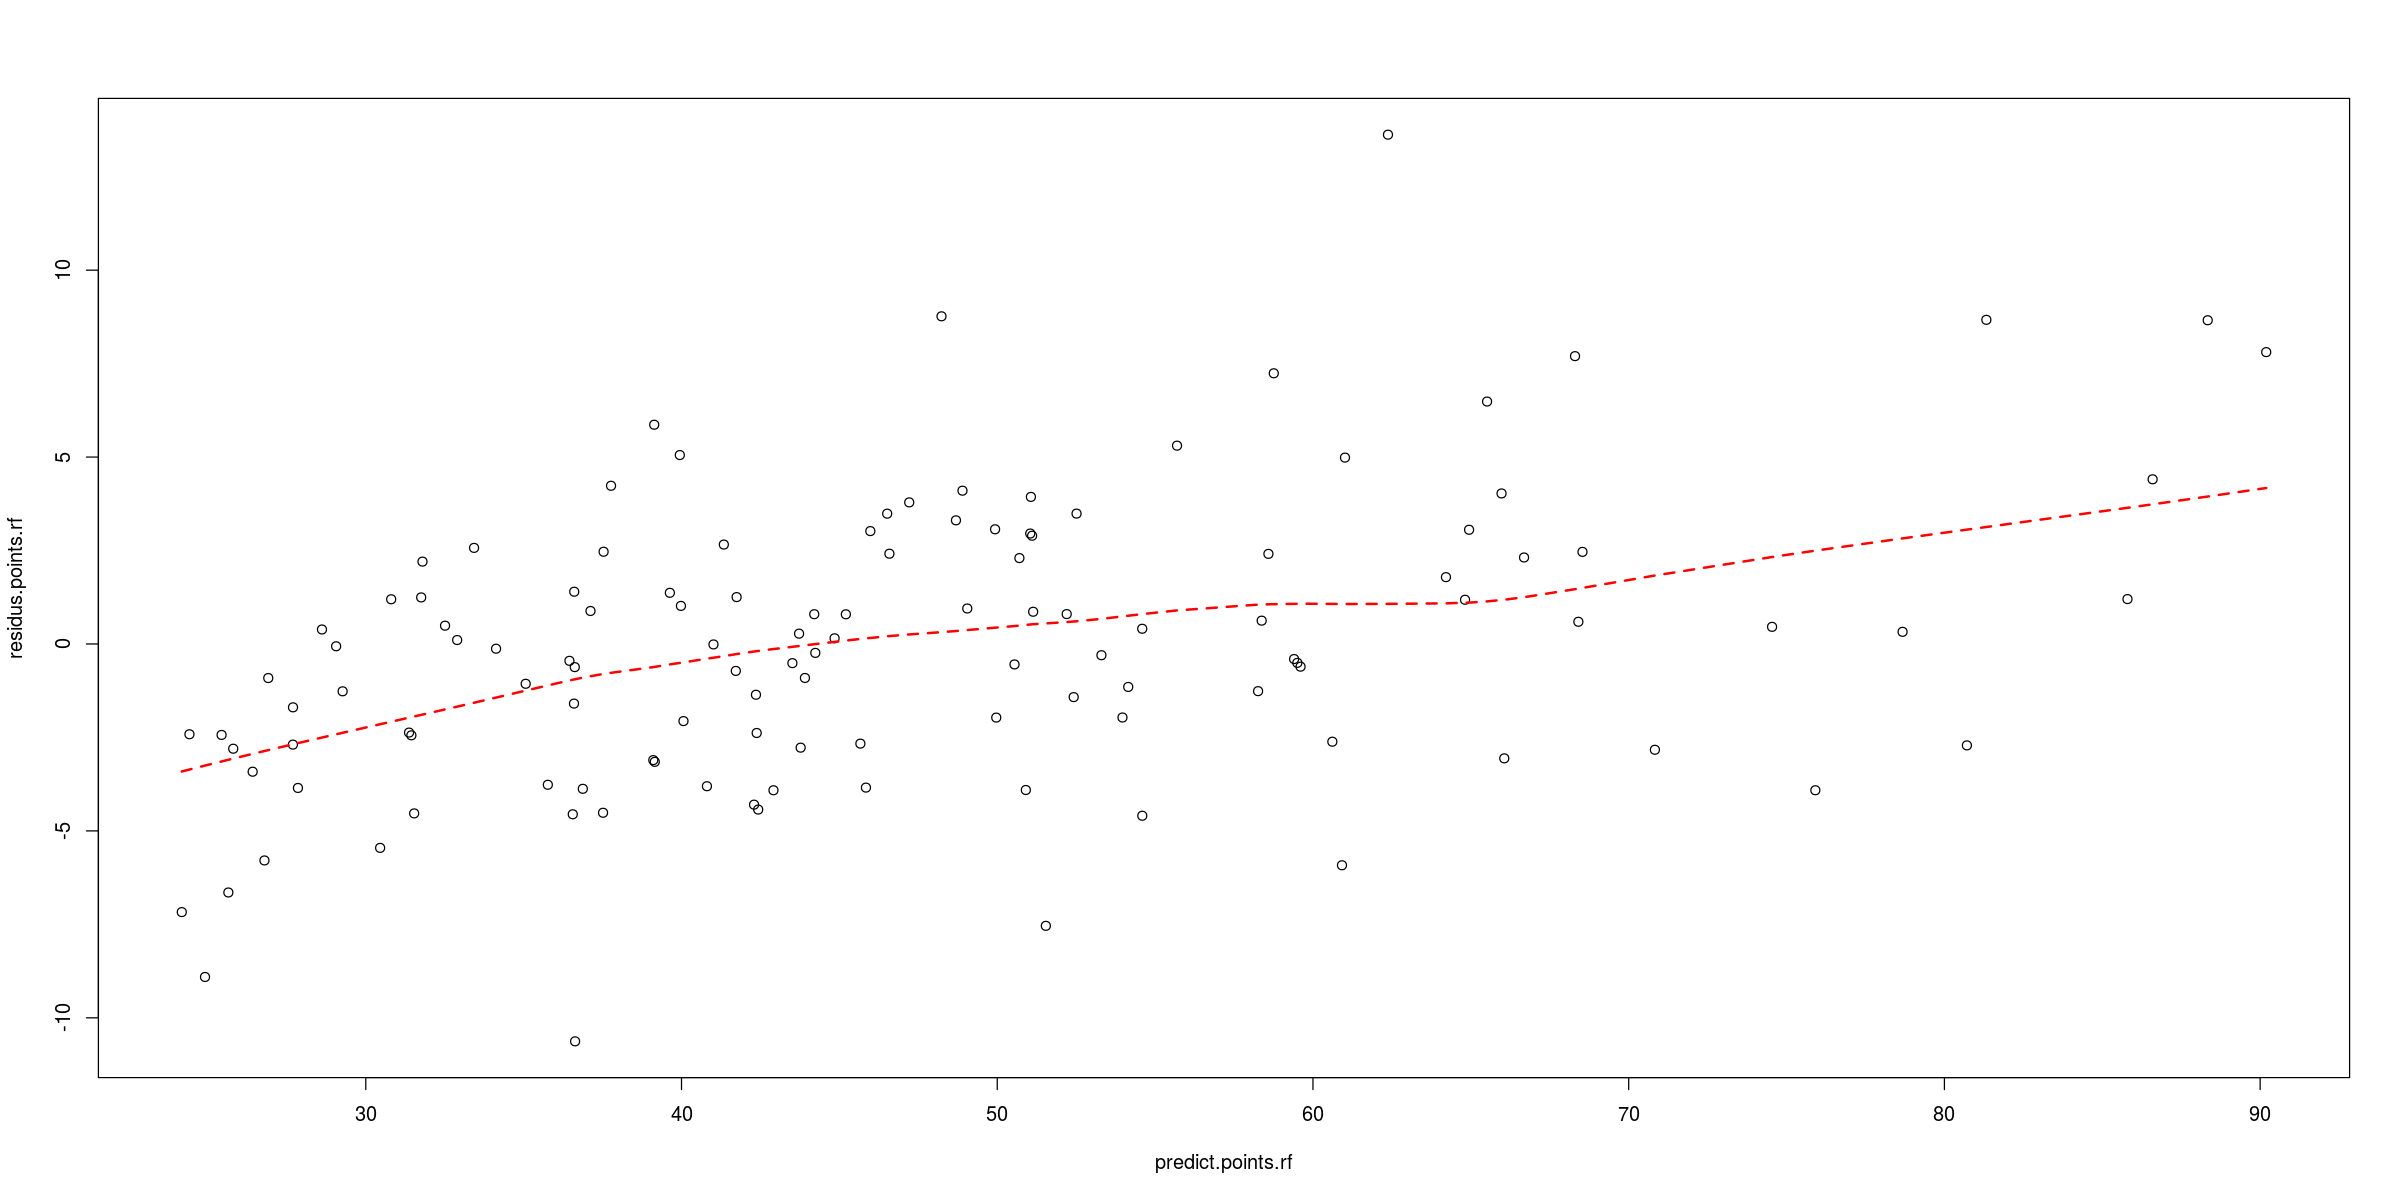

In [10]:
plot(predict.points.rf, residus.points.rf)
lines(lowess(predict.points.rf, residus.points.rf), col = 2, lty = 2, lwd = 2)

In [11]:
r.squared.points = 1-sum(residus.points.rf**2)/(length(data_tot$Points)*var(data_tot$Points))
r.squared.points

[1] 0.9513835

In [12]:
sum(residus.points.rf**2)/124*300

[1] 4430.434

## SVM sur la variable Points

In [14]:
svm.points = svm(data_tot$Points ~ ., data=data_but_tot, kernel="radial")

In [15]:
svm.predict.points = predict(svm.points, data_but_tot)

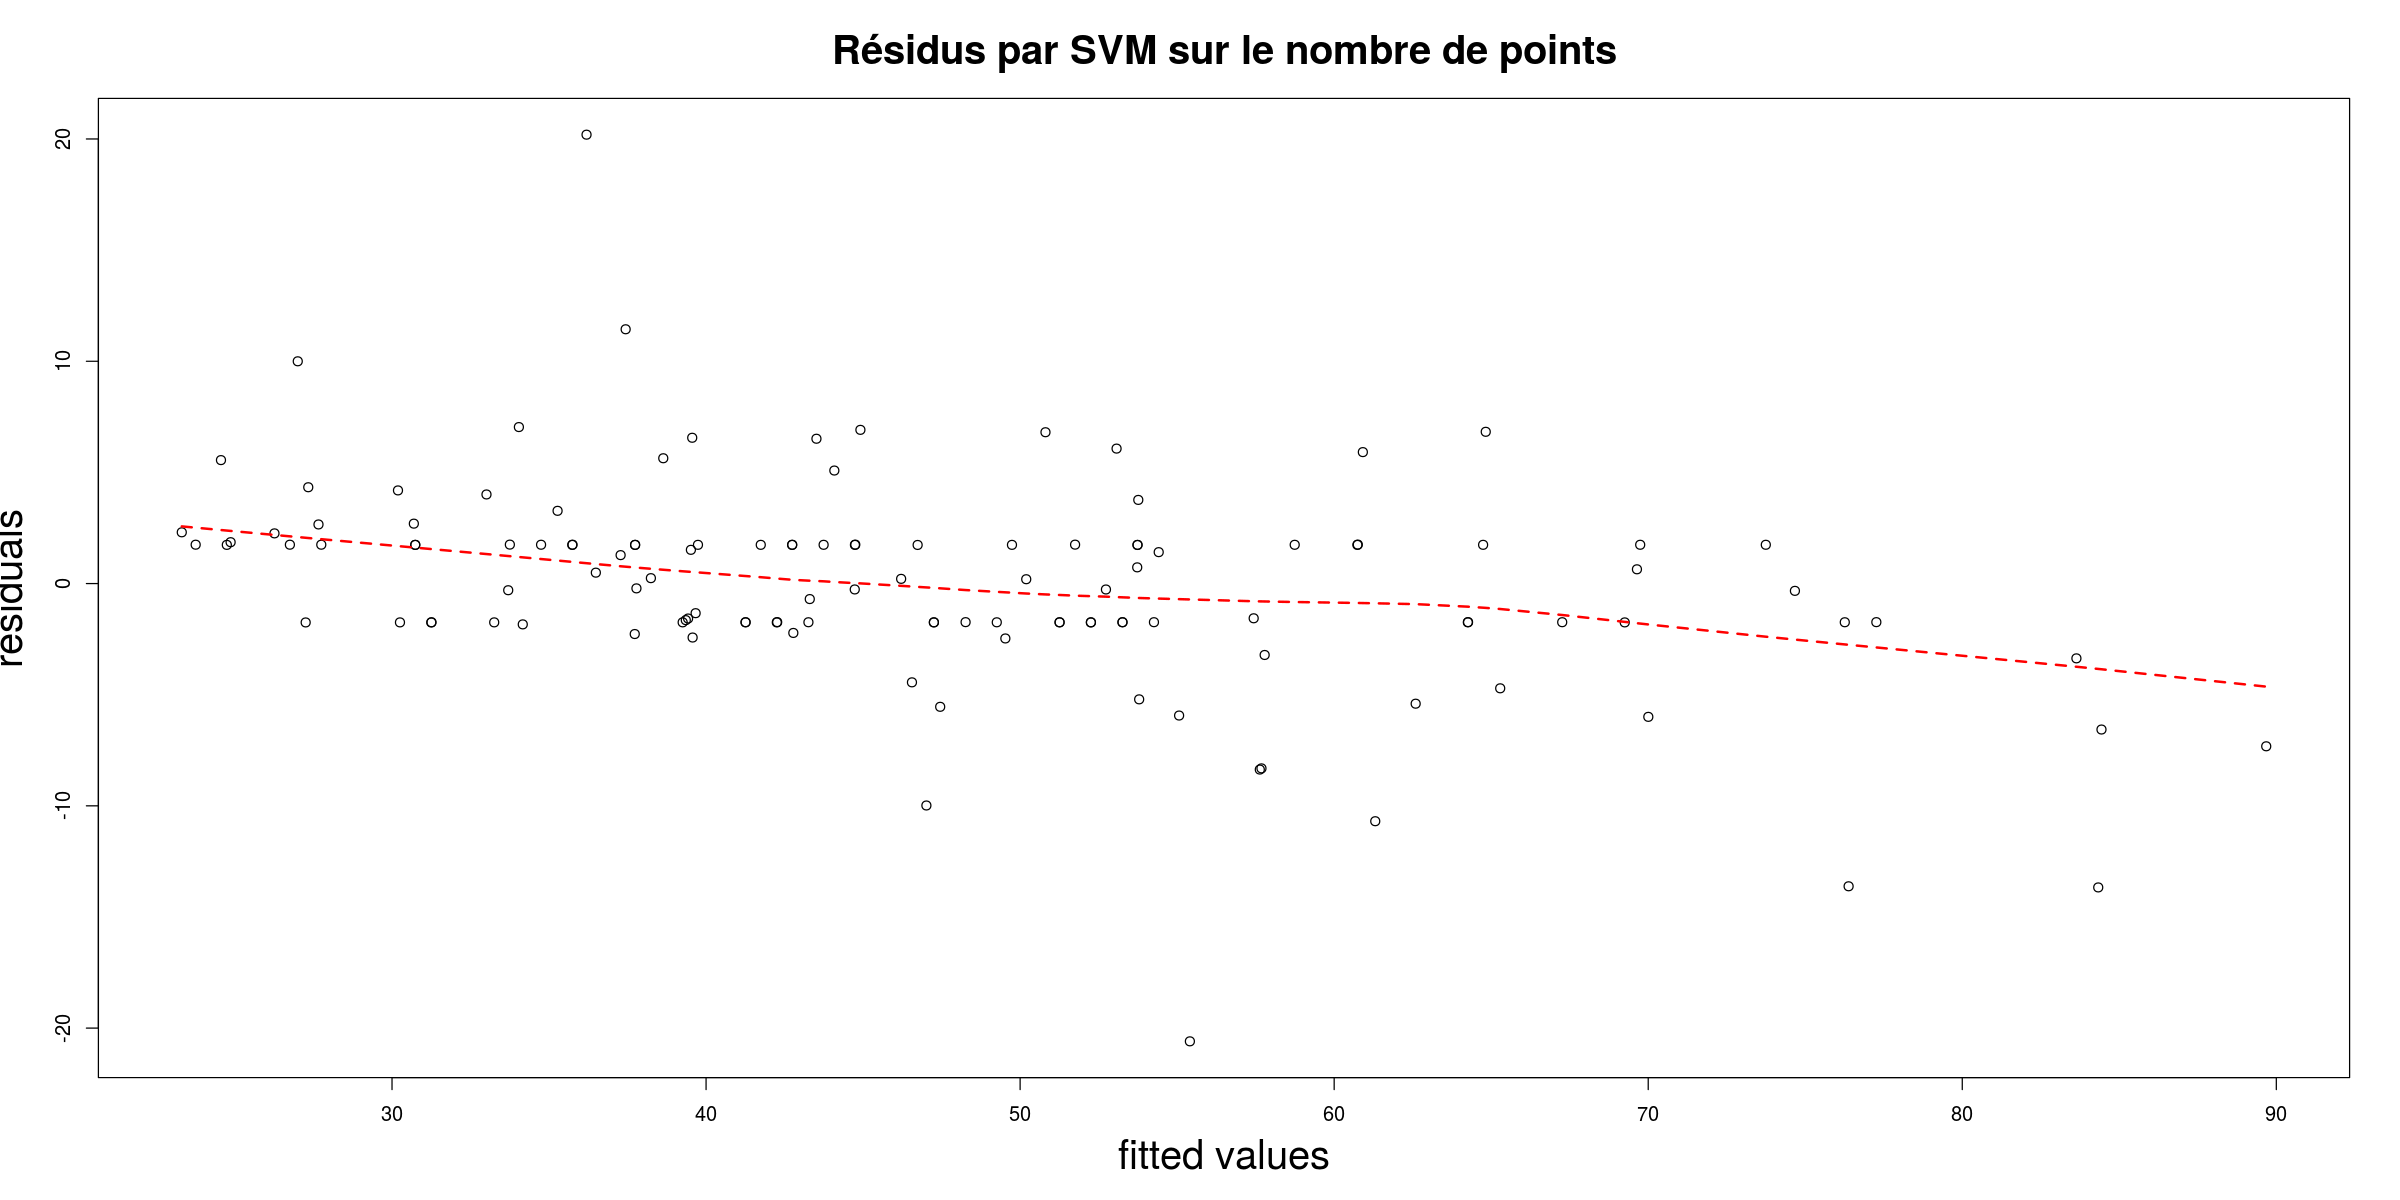

In [16]:
residus.svm.points = svm.predict.points - data_tot$Points
plot(svm.predict.points, residus.svm.points, main = "Résidus par SVM sur le nombre de points", 
     cex.main = 2, xlab = "fitted values", ylab = "residuals", cex.lab = 2)
lines(lowess(svm.predict.points, residus.svm.points), col = 2, lty = 2, lwd = 2)

In [17]:
R2svm.points = 1 - sum(residus.svm.points ^ 2)/(length(data_tot$Points)*var(data_tot$Points))

In [18]:
R2svm.points

[1] 0.9238677

Ici le $R^2$ est très bon, car proche de 1, et les résidus sont corrects aussi.

**Problème** : on n'arrive pas à extraire de modèle basé sur SVM, ie récupérer les variables qui ont le plus d'importance (peut-être trouver celles pour lesquelles la séparation est la plus facile ?)

## NNET

In [19]:
nnet.points = avNNet(data_but_tot, data_tot$Points, size=14)

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


Fitting Repeat 1 

# weights:  757
initial  value 309017.113124 
final  value 304182.000000 
converged
Fitting Repeat 2 

# weights:  757
initial  value 310226.645678 
final  value 304182.000000 
converged
Fitting Repeat 3 

# weights:  757
initial  value 306936.318831 
final  value 304182.000000 
converged
Fitting Repeat 4 

# weights:  757
initial  value 311061.709333 
final  value 304182.000000 
converged
Fitting Repeat 5 

# weights:  757
initial  value 308426.134659 
final  value 304182.000000 
converged


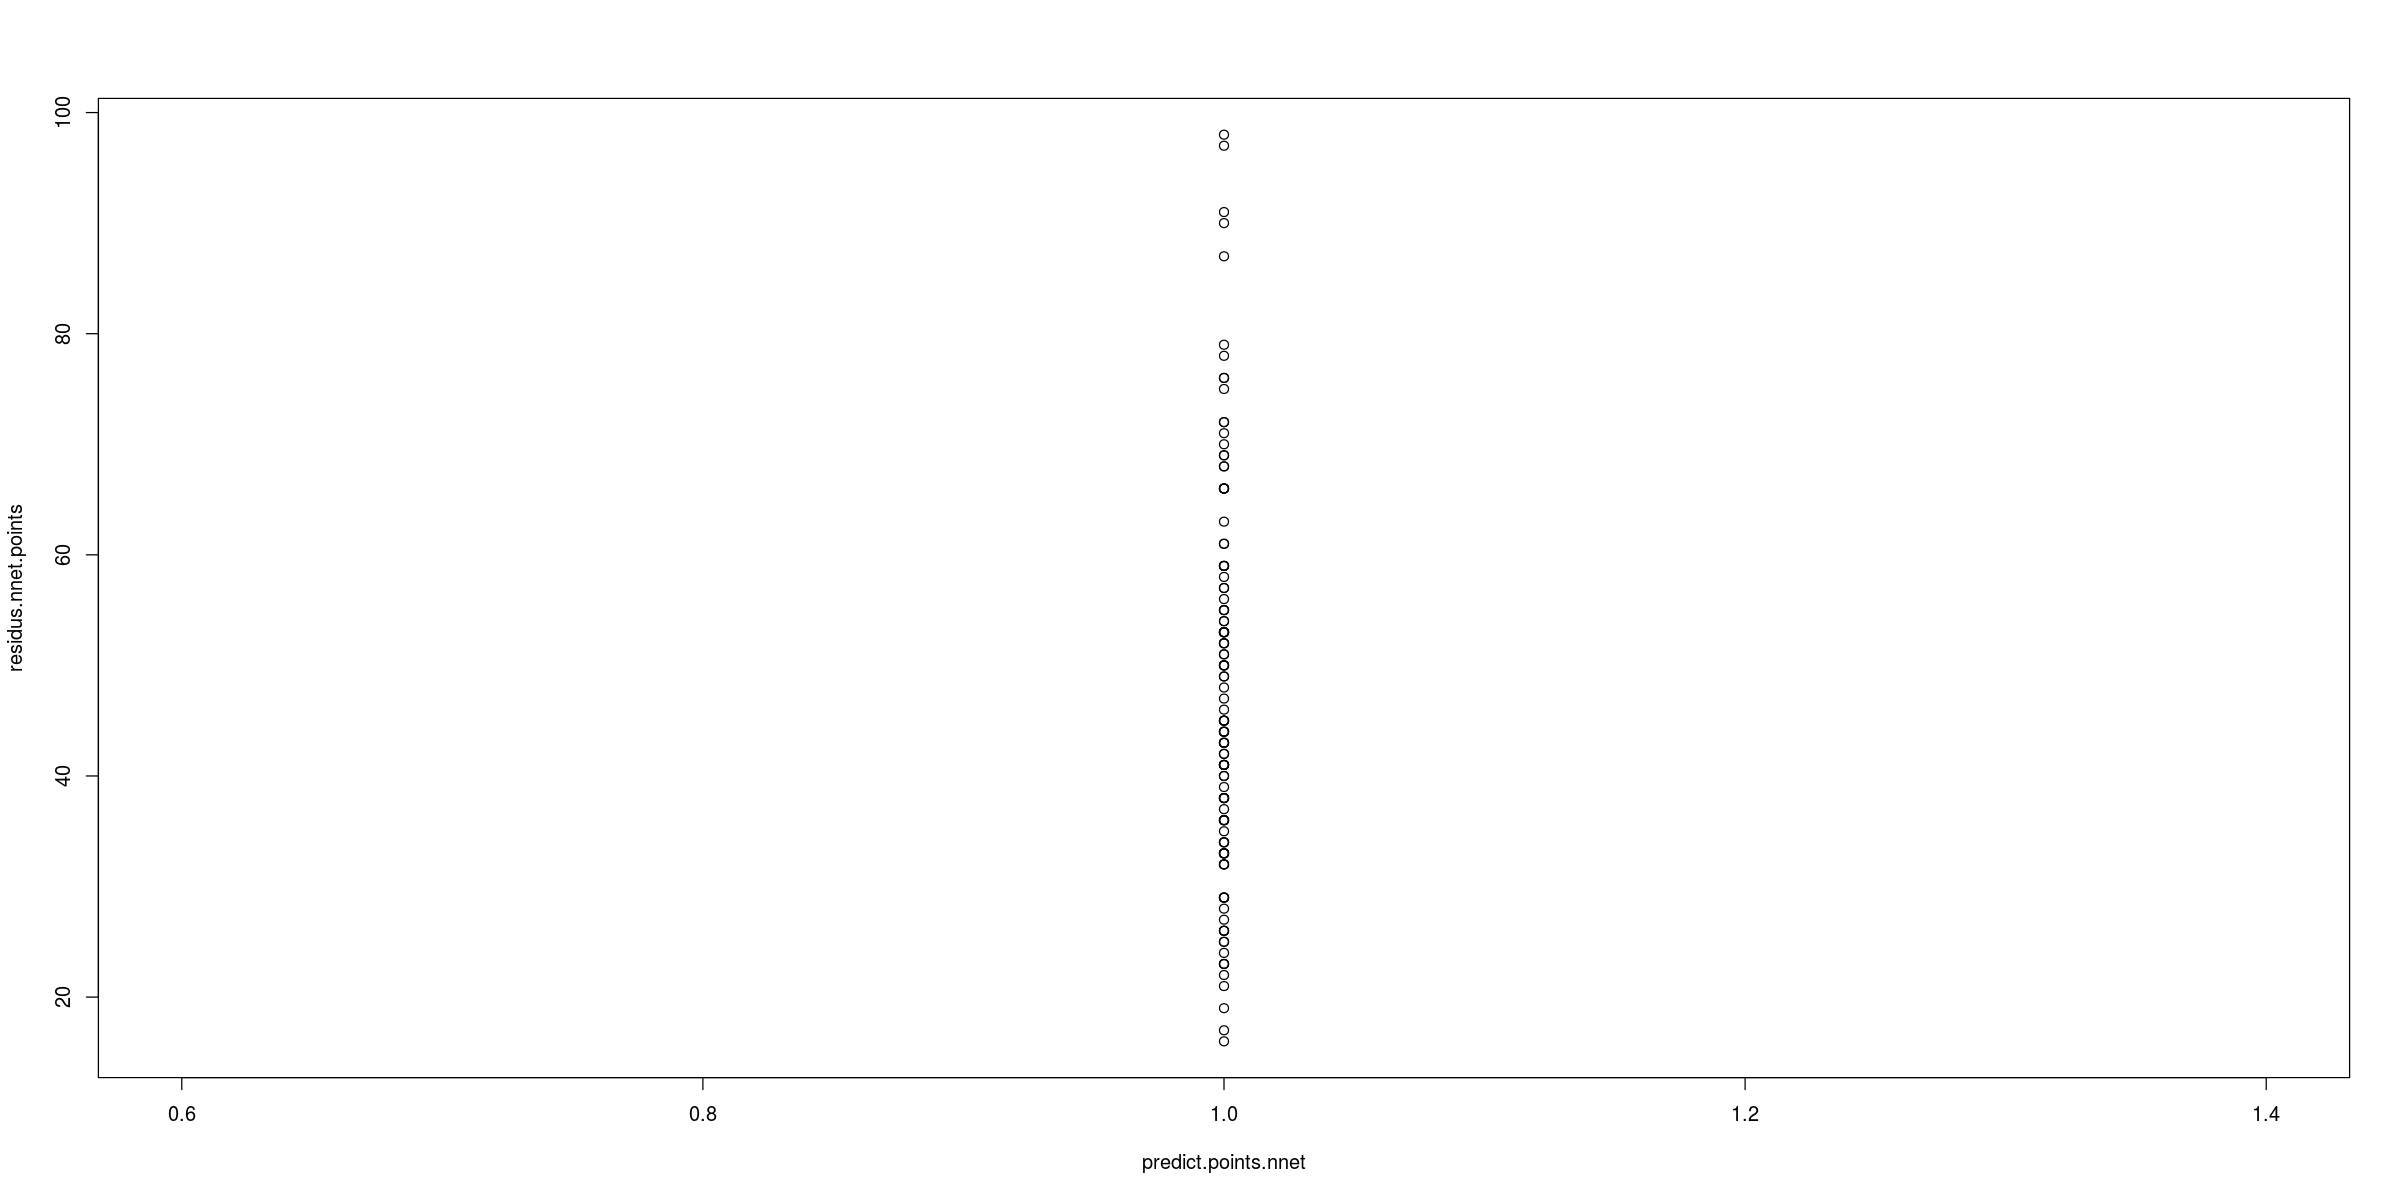

In [20]:
predict.points.nnet = predict(nnet.points, data, type="raw")
residus.nnet.points = data_tot$Points
plot(predict.points.nnet, residus.nnet.points)

**Problème** : on n'arrive pas à se servir de nnet ici, tout est prédit à 1.  
En plus, comment réussir à extraire des variables importantes avec un réseau de neurones sachant qu'il calcule lui même des features ?